### Load and Chunk Documents

In [1]:
import gzip
import json
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

wikipedia_filepath = r"D:\Ineuron-materials-FSDS\Gen AI\Learning-langgraph\data\simplewiki-2020-11-01.jsonl.gz"

docs = []
with gzip.open(wikipedia_filepath, "rt", encoding="utf8") as fIn:
    for line in fIn:
        data = json.loads(line.strip())
        docs.append({
            "metadata": {
                "title": data.get("title"),
                "article_id": data.get("id"),
            },
            "data": " ".join(data.get("paragraphs")[0:3])  # restrict to 3 paragraphs
        })

# Filter docs containing 'india'
docs = [doc for doc in docs if "india" in doc["data"].lower()]

# Convert to LangChain Document objects
docs = [
    Document(page_content=doc["data"], metadata=doc["metadata"])
    for doc in docs
]

# Chunk docs
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=300)
chunked_docs = splitter.split_documents(docs)

# Inspect first 3 chunks
print(chunked_docs[:3])


[Document(metadata={'title': 'Far East', 'article_id': '85954'}, page_content='The term Far East means countries of East Asia. It became used in the English language during the period of the British Empire for lands to the east of British India. Before World War I, the "Near East" meant relatively nearby lands of the Ottoman Empire, "Middle East" northwestern South Asia and Central Asia, and "Far East" countries along the western Pacific Ocean and countries along the eastern Indian Ocean. Many European languages have analogous terms, such as the French \', Spanish \', Portuguese \', German \', Italian \', and Dutch \'. "Far East" is never used for the culturally Western nations of Australia and New Zealand, which lie even farther to the east of Europe than much of East Asia.'), Document(metadata={'title': 'Hair iron', 'article_id': '86329'}, page_content="A hair iron or hair tong is something people use to change the shape of the hair by heating it. There are three types of hair iron: 

### Create a Vector DB and Persist on the Disk

In [2]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
import os
def get_api_key(api_key_name):
        return os.getenv(api_key_name)

# embedding_model = GoogleGenerativeAIEmbeddings(
#             model="models/embedding-001",
#             google_api_key=get_api_key("GOOGLE_API_KEY")
#)
from langchain_openai import OpenAIEmbeddings
# details here: https://openai.com/blog/new-embedding-models-and-api-updates
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

d:\Ineuron-materials-FSDS\Gen AI\Learning-langgraph\langgraph\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
from langchain_chroma import Chroma
# create vector DB of docs and embeddings - takes < 30s on Colab
import shutil

# Delete the old DB that was created with 768
#shutil.rmtree("./wikipedia_db", ignore_errors=True)
persist_dir = "./wikipedia_db"
# Rebuild DB with your current embedding model (1536-dim OpenAI)
# chroma_db = Chroma.from_documents(
#     documents=chunked_docs,
#     collection_name="rag_wikipedia_db",
#     embedding=openai_embed_model,
#     collection_metadata={"hnsw:space": "cosine"},
#     persist_directory="./wikipedia_db"
# )
# Check if the vector DB already exists
from langchain_chroma import Chroma
import os

persist_dir = "./wikipedia_db"

if os.path.exists(persist_dir) and os.listdir(persist_dir):
    # Load existing DB — do NOT pass embedding here
    chroma_db = Chroma(
        collection_name="rag_wikipedia_db",
        persist_directory=persist_dir
    )
else:
    # Create DB for the first time
    chroma_db = Chroma.from_documents(
        documents=chunked_docs,
        collection_name="rag_wikipedia_db",
        embedding=openai_embed_model,
        collection_metadata={"hnsw:space": "cosine"},
        persist_directory=persist_dir
    )
    chroma_db.persist()


In [4]:
similarity_threshold_retriever = chroma_db.as_retriever(search_type="similarity_score_threshold",
						search_kwargs={"k": 3,
						"score_threshold": 0.3})
#We can then test if our retriever is working on some sample queries.
query = "what is the capital of India?"
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

[Document(id='21baa11d-58bf-4012-a8d1-9a8d1fc4cc5a', metadata={'title': 'New Delhi', 'article_id': '5117'}, page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7\xa0km. New Delhi has a population of about 9.4 Million people.'),
 Document(id='62b41862-09e6-4608-a506-e35fe74a3a18', metadata={'article_id': '5114', 'title': 'Mumbai'}, page_content="Mumbai (previously known as Bombay until 1996) is a natural harbor on the west coast of India, and is the capital city of Maharashtra state. It is India's largest city, and one of the world's most populous cities. It is the financial capital of India. The city is the second most-populous in the world. It has approximately 13 million people. Along with the neighboring cities of Navi Mumbai and Thane, i

In [5]:
query = "what is langgraph?"
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

[Document(id='12828a68-1e1b-4813-8f27-93aaf2c833ea', metadata={'title': 'Langur', 'article_id': '97946'}, page_content='The Gray langur or Hanuman langur (Semnopithecus) is a genus of colobine monkey. They are found in southeast Asia. The word "langur" means \'having a long tail\'. It is commonly called the leaf monkey. They usually live in small groups of between 2 and 10 individuals. They mainly eat leaves, as well as some fruit. Langur spend most of their time in trees. They have white fur and black faces. They are considered sacred animals therefore the "National social mammal of India".'),
 Document(id='12453f7a-c392-400c-a37f-24b58a04272a', metadata={'title': 'Larkana', 'article_id': '145104'}, page_content='Larkana or Larkano (لاڑکانہ) is city of Sindh Province, Pakistan. The city is the capital of Larkana District. In August 2000 Larkana celebrated its hundred years of existence. It is located on the south bank of the Ghar canal, 40 miles south of Shikarpur town, and 36 north-e

In [20]:
# from langchain_groq import ChatGroq
# llm =ChatGroq(
#     api_key = get_api_key("GROQ_API_KEY") ,
#     model = "llama-3.1-8b-instant",
#     temperature =0.4 ,
#     max_retries =3
# )
# print(llm)

In [8]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

# Data model for LLM output format
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM for grading
llm = ChatOpenAI(model="gpt-5-nano", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt template for grading
SYS_PROMPT = """You are an expert grader assessing relevance of a retrieved document to a user question.
Follow these instructions for grading:
  - If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
  - Your grade should be either 'yes' or 'no' to indicate whether the document is relevant to the question or not."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Retrieved document:
{document}
User question:
{question}
"""),
    ]
)

# Build grader chain
doc_grader = grade_prompt | structured_llm_grader


d:\Ineuron-materials-FSDS\Gen AI\Learning-langgraph\langgraph\Lib\site-packages\langchain_openai\chat_models\base.py:1914: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


In [9]:
query = "what is the capital of India?"
top3_docs = similarity_threshold_retriever.invoke(query)

for doc in top3_docs:
    print(doc.page_content)
    print('GRADE:', doc_grader.invoke({
        "question": query,
        "document": doc.page_content
    }))
    print()


New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7 km. New Delhi has a population of about 9.4 Million people.
GRADE: binary_score='yes'

Mumbai (previously known as Bombay until 1996) is a natural harbor on the west coast of India, and is the capital city of Maharashtra state. It is India's largest city, and one of the world's most populous cities. It is the financial capital of India. The city is the second most-populous in the world. It has approximately 13 million people. Along with the neighboring cities of Navi Mumbai and Thane, it forms the world's 4th largest urban agglomeration. They have around 19.1 million people. The seven islands that form Bombay were home to fishing colonies. The islands were ruled by successive kingdoms and indigenous em

In [10]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

# Create RAG prompt for response generation
prompt = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If no context is present or if you don't know the answer, just say that you don't know the answer.
Do not make up the answer unless it is there in the provided context.
Give a detailed answer and to the point answer with regard to the question.
Question:
{question}
Context:
{context}
Answer:
"""

prompt_template = ChatPromptTemplate.from_template(prompt)

# Initialize connection with GPT-4o
chatgpt = ChatOpenAI(model_name='gpt-5-nano', temperature=0)

# Used for separating context docs with new lines
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Create QA RAG chain
qa_rag_chain = (
    {
        "context": (
            itemgetter('context')
            | RunnableLambda(format_docs)
        ),
        "question": itemgetter('question')
    }
    | prompt_template
    | chatgpt
    | StrOutputParser()
)


In [11]:
query = "what is the capital of India?"

top3_docs = similarity_threshold_retriever.invoke(query)

result = qa_rag_chain.invoke(
    {"context": top3_docs, "question": query}
)

print(result)


New Delhi.


In [12]:
query = "who won the champions league in 2024?"

top3_docs = similarity_threshold_retriever.invoke(query)

result = qa_rag_chain.invoke(
    {"context": top3_docs, "question": query}
)

print(result)


I don’t know the answer from the provided context. The supplied material only covers cricket and baseball and does not mention the UEFA Champions League or its 2024 winner. If you’d like, I can help look up the result.


In [13]:
# LLM for question rewriting
llm = ChatOpenAI(model="gpt-5-nano", temperature=0)

# Prompt template for rewriting
SYS_PROMPT = """Act as a question re-writer and perform the following task:
                 - Convert the following input question to a better version that is optimized for web search.
                 - When re-writing, look at the input question and try to reason about the underlying semantic intent / meaning.
             """

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            SYS_PROMPT
        ),
        (
            "human",
            """Here is the initial question:
               {question}
               Formulate an improved question.
            """,
        ),
    ]
)

# Create rephraser chain
question_rewriter = (
    re_write_prompt
    | llm
    | StrOutputParser()
)


In [14]:
query = "who won the champions league in 2024?"
question_rewriter.invoke({"question": query})

'Who won the UEFA Champions League in the 2023–24 season?'

In [15]:
from langchain_community.tools.tavily_search import TavilySearchResults
tv_search = TavilySearchResults(max_results=3, search_depth='advanced',max_tokens=10000)

C:\Users\NABEEL AHMED\AppData\Local\Temp\ipykernel_27896\3206506337.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tv_search = TavilySearchResults(max_results=3, search_depth='advanced',max_tokens=10000)


In [16]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM response generation
        web_search_needed: flag of whether to add web search - yes or no
        documents: list of context documents
    """
    question: str
    generation: str
    web_search_needed: str
    documents: List[str]


In [17]:
def retrieve(state):
    """
    Retrieve documents
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, documents - that contains retrieved context documents
    """
    print("---RETRIEVAL FROM VECTOR DB---")
    question = state["question"]
    # Retrieval
    documents = similarity_threshold_retriever.invoke(question)
    return {"documents": documents, "question": question}


In [18]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    by using an LLM Grader.
    If any document are not relevant to question or documents are empty - Web Search needs to be done
    If all documents are relevant to question - Web Search is not needed
    Helps filtering out irrelevant documents
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search_needed = "No"

    if documents:
        for d in documents:
            score = doc_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score.binary_score
            if grade == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d)
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
                web_search_needed = "Yes"
                continue
    else:
        print("---NO DOCUMENTS RETRIEVED---")
        web_search_needed = "Yes"

    return {
        "documents": filtered_docs,
        "question": question,
        "web_search_needed": web_search_needed,
    }


In [19]:
def rewrite_query(state):
    """
    Rewrite the query to produce a better question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates question key with a re-phrased or re-written question
    """
    print("---REWRITE QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})

    return {
        "documents": documents,
        "question": better_question,
    }


In [20]:
from langchain.schema import Document

def web_search(state):
    """
    Web search based on the re-written question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = tv_search.invoke(question)
    web_results = "\n\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {
        "documents": documents,
        "question": question,
    }


In [21]:
def generate_answer(state):
    """
    Generate answer from context document using LLM
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE ANSWER---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = qa_rag_chain.invoke({"context": documents, "question": question})

    return {
        "documents": documents,
        "question": question,
        "generation": generation,
    }


In [22]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    web_search_needed = state["web_search_needed"]

    if web_search_needed == "Yes":
        # Some or all documents are not relevant
        print("---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---")
        return "rewrite_query"
    else:
        # All documents are relevant
        print("---DECISION: GENERATE RESPONSE---")
        return "generate_answer"


In [23]:
from langgraph.graph import END, StateGraph

agentic_rag = StateGraph(GraphState)

# Define the nodes
agentic_rag.add_node("retrieve", retrieve)  # retrieve
agentic_rag.add_node("grade_documents", grade_documents)  # grade documents
agentic_rag.add_node("rewrite_query", rewrite_query)  # transform_query
agentic_rag.add_node("web_search", web_search)  # web search
agentic_rag.add_node("generate_answer", generate_answer)  # generate answer

# Build graph
agentic_rag.set_entry_point("retrieve")
agentic_rag.add_edge("retrieve", "grade_documents")

agentic_rag.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"rewrite_query": "rewrite_query", "generate_answer": "generate_answer"},
)

agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer")
agentic_rag.add_edge("generate_answer", END)

# Compile
agentic_rag = agentic_rag.compile()


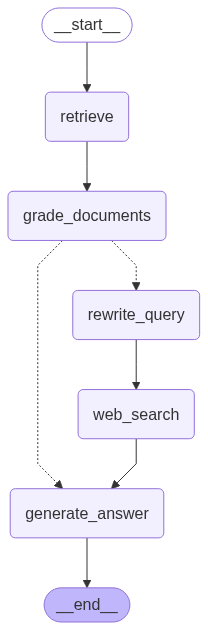

In [24]:
from IPython.display import Image, display, Markdown
display(Image(agentic_rag.get_graph().draw_mermaid_png()))

In [25]:
query = "what is the capital of India?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---


In [26]:
display(Markdown(response['generation']))

New Delhi. It is the capital of India and a union territory within the megacity of Delhi.

In [27]:
query = "who won the champions league in 2024?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---


In [28]:
display(Markdown(response['generation']))

- 2023–24 UEFA Champions League title winner: Real Madrid.
- 2024 UEFA Champions League final winner: Real Madrid.
- 2024 final score: Real Madrid 2–0 Borussia Dortmund.

In [29]:
query = "Tell me about India"
response = agentic_rag.invoke({"question": query})
display(Markdown(response['generation']))

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---


Here is a concise overview of India based on the provided context:

- Location and geography
  - India is a country in Asia, at the center of South Asia. It is a peninsula bounded by the Indian Ocean (south), the Arabian Sea (west), and the Bay of Bengal (east).
  - It is the seventh largest country in the world by area and the largest country in South Asia. The coastline is described in the text but a specific length isn’t provided.

- Population and governance
  - Population: more than 1.2 billion people, the second largest population in the world.
  - It is the most populous democracy in the world.
  - The capital city is New Delhi.

- Neighbors
  - India has seven neighbors: Pakistan (northwest), China and Nepal (north), Bhutan and Bangladesh (northeast), Myanmar (east), and Sri Lanka (south, an island).

- Military and defense
  - India has the third largest military force in the world.
  - It is a nuclear weapon state.

- History (highlights)
  - The history covers thousands of years with diversity in languages, cultures, periods, and dynasties.
  - Civilizational roots trace to the Indus Valley; evidence of early humans (Homo erectus) in India dating 200,000–500,000 years ago.
  - The Soanian paleolithic sites are found in the region.

- Economy
  - The economy is the fifth largest in the world by GDP (about $2.94 trillion).
  - PPP (purchasing power parity) basis is about $10.51 trillion, making it the third largest in PPP terms.
  - Per capita PPP (2015) was about $6,209 per year.
  - Sectors: agriculture, handicrafts, industry, and services, with the service sector as the main source of growth today.
  - A large portion of the population earns livelihoods connected to agriculture (two-thirds).
  - India became a pioneer in information technology due to a well-educated, English-speaking workforce.
  - Historically, the economy had extensive government controls, especially in telecommunications, banking, and foreign investment. Since the early 1990s, it has liberalized and opened up to foreign trade and investment, helping growth. This liberalization began under Prime Minister P. V. Narasimha Rao with the leadership of Manmohan Singh.

Overall takeaway: India is a vast, densely populated, historically rich country in South Asia with a diverse economy, strong service and IT sectors, a long-standing democratic system, and significant cultural and linguistic variety.